In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Código ON/OFF</button>''', raw=True)

Código ON/OFF

In [2]:
# importing libraries
from pandas_datareader import data as pdr
import monthly_returns_heatmap as mrh
import matplotlib.pyplot as plt
import plotly.plotly as py
import seaborn as sns
import pandas as pd
import numpy as np
import plotly
import time

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from matplotlib.ticker import FuncFormatter
from datetime import datetime

# Setting pandas dataframe display options
pd.set_option("display.max_rows", 20)
pd.set_option('display.width', 800)
pd.set_option('max_colwidth', 800)

# Set plotly offline
init_notebook_mode(connected=True)

# Set matplotlib style
plt.style.use('seaborn')

import cufflinks as cf
cf.go_offline()

#### Functions ####
def compute_drawdowns(dataframe):
    '''
    Function to compute drawdowns of a timeseries
    given a dataframe of prices
    '''
    return (dataframe / dataframe.cummax() -1) * 100
    
def compute_max_DD(dataframe):
    return compute_drawdowns(dataframe).min().abs()

def compute_cagr(dataframe, years=0):
    '''
    Function to calculate CAGR given a dataframe of prices
    '''
    return (dataframe.iloc[-1].div(dataframe.iloc[0]).pow(1 / years)).sub(1).mul(100)

def compute_romad(dataframe):
    '''
    Function to calculate RoMaD: Return Over Maximum Drawdown
    given a dataframe of prices
    '''
    return compute_cagr(dataframe).div(compute_drawdowns(dataframe).min().abs())

def compute_StdDev(dataframe, freq='days'):    
    '''
    Function to calculate annualized standart deviation
    given a dataframe of prices. It takes into account the
    frequency of the data.
    '''    
    if freq == 'days':
        return dataframe.pct_change().std().mul((np.sqrt(252))).mul(100)
    if freq == 'months':
        return dataframe.pct_change().std().mul((np.sqrt(12))).mul(100)

def compute_sharpe(dataframe, years=0, freq='days'):    
    '''
    Function to calculate the sharpe ratio given a dataframe of prices.
    '''    
    return compute_cagr(dataframe, years).div(compute_StdDev(dataframe, freq))

def compute_performance_table(dataframe, years='si', freq='days'):    
    '''
    Function to calculate a performance table given a dataframe of prices.
    Takes into account the frequency of the data.    
    ''' 
    
    if years == 'si':
        years = len(pd.date_range(dataframe.index[0], dataframe.index[-1], freq='D')) / 365.25
        
        df = pd.DataFrame([compute_cagr(dataframe, years), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD']
        return round(df, 2)        
    
    else:
        df = pd.DataFrame([compute_cagr(dataframe, years), compute_StdDev(dataframe, freq),
                           compute_sharpe(dataframe, years, freq), compute_max_DD(dataframe)])
        df.index = ['CAGR', 'StdDev', 'Sharpe', 'Max DD']
        return round(df, 2)

def filter_by_date(dataframe, years=0, previous_row=False):
    
    last_date = fundos.tail(1).index
    year_nr = last_date.year.values[0]
    month_nr = last_date.month.values[0]
    day_nr = last_date.day.values[0]
            
    new_date = str(year_nr - years) + '-' + str(month_nr) + '-' + str(day_nr)
    
    if previous_row == False:
        return dataframe.loc[new_date:]
    
    elif previous_row == True:
        return pd.concat([dataframe.loc[:new_date].tail(1), dataframe.loc[new_date:]])
    
# Multi_period_return (in CAGR)
def multi_period_return(df, years = 1):
    shifted = Portfolios.shift(252 * years)
    One_year = (((1 + (Portfolios - shifted) / shifted) ** (1 / years))-1)  * 100
    return One_year

Este ficheiro tem como objectivo explicar 5 importantes conceitos para perceber o mundo dos investimentos.

O objectivo será responder a 3 questões fundamentais:
* Porquê investir?
* Como investir?
* Por quanto tempo se deve investir?

Para responder à primeira questão falarei da **Inflação e perda do poder de compra** que deriva dela.

Para responder à segunda questão explicarei as teorias base para criação de uma carteira de investimento. O que é verdadeiramente a **Diversificação e correlação entre fundos** e finalmente o conceito de **Simulações de Monte Carlo e Fronteira Eficiente de Markowitz*

Por último irei falar de 2 conceitos, o **Valor temporal do dinheiro e o poder dos juros de juros** e também da **Menor variabilidade nos retornos de longo prazo**. Ambos para demostrar que devemos investir a longo prazo. 

# 1- Porquê investir?

### 1.1 Inflação e da perda do poder de compra

Penso que todos estamos familiarizados com a inflação. Vamos-nos apercebendo que os produtos estão cada vez mais caros ao longo do tempo e que isso deriva da inflação.

Apresento contudo a idea de outro ponto de vista. O dinheiro é que vai perdendo o seu valor. Não é o café que vai subindo de preço mas sim o dinheiro com que o vamos comprar que vai perdendo valor e temos de aumentar o montante. Isso resulta não só num aumento de preço do café, mas sim num aumento **generalizado e sustentável** dos preços dos bens, exactamente o conceito de inflação. 

Esta perda do poder de compra do dinheiro é a verdadeira génese do problema e irei tentar transmitir isso com uma simulação de perda de valor do dinheiro em 50 anos só com uma inflação de 2% (em linha com o objectivo do BCE):

In [3]:
%%capture

anos = np.arange(1, 51)

df = pd.DataFrame(anos)

df['Principal'] = 100

df.columns = ['Ano', 'Principal']

df['Ajustado à inflação'] = 0
df['Ajustado à inflação'][0] = 100

df.set_index('Ano', inplace=True)

for i in np.arange(1, len(df)):
    df['Ajustado à inflação'].iloc[i] = df['Ajustado à inflação'].iloc[i -1] * 0.98

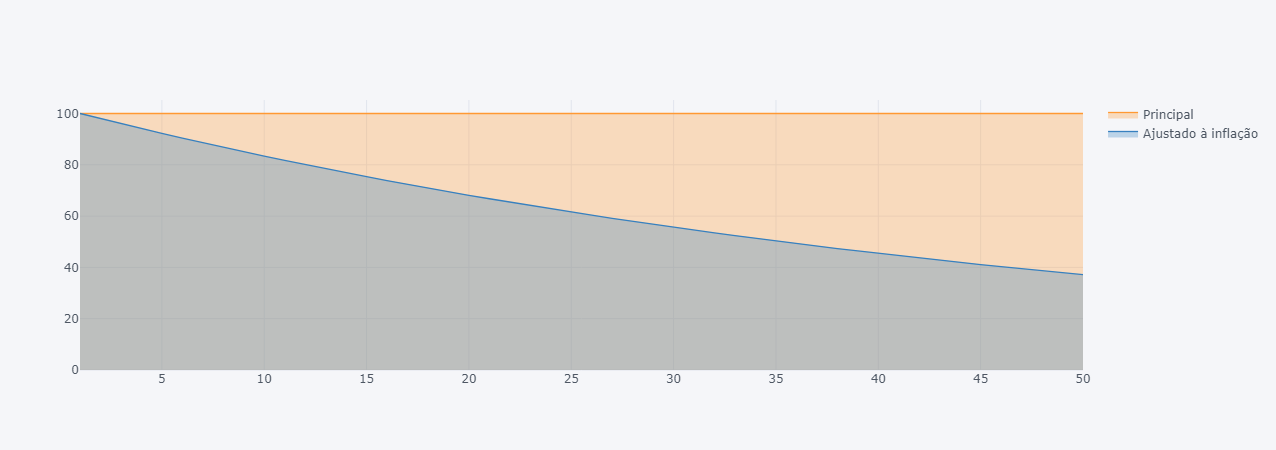

In [5]:
round(df, 2).iplot(fill=True)

Em cima como podemos ver o valor do "Principal" (jargão financeiro que apenas significa "valor investido inicialmente"). Como podemos ver o valor nominal é sempre 100 euros. Um depósito à ordem no valor de 100 euros muito provavelmente valerá 100 euros daqui a 50 anos.

Contudo, isso é o valor nominal. Daqui a 50 anos 100 euros com certeza valerão menos do que valem hoje. Podemos calcular qual será o valor real que terão, caso o BCE seja bem sucedido e mantiver a inflação nuns "baixos" 2%. O valor real desses 100 euros daqui a  50 anos será 37.16 euros de hoje.

Esta é a razão pelo qual devemos investir e que distingue investimento de poupança. Todos sabemos as razões que nos levam a poupar, seja a compra de casa, reforma, ou faculdade dos filhos. Isso são as razões de poupança. O investimento, por seu lado, tem como objectivo primário que essa poupança não perca o seu valor real ao longo do tempo.

# 2 - Como investir?

Esta secção será focada em responder à questão de como investir.  Terá conceitos fundamentais sobre como construir uma carteira de investimento, sendo a preparação para efectivamente construir uma carteira de fundos com base em teorias financeiras com que possamos investir.  Embora as teorias sejam já relativamente antigas são os alicerces de qualquer construção de uma boa carteira. Com o advento do poder computacional foi-se tornando possível a aplicação destas teorias com vários activos financeiros. Vamos aplicar aos fundos comerciizados em Portugal o melhor que vejo ser feito por esse mundo fora, principalmente nos EUA.

Infelizmente na Europa desconheço ferramentas que nos permitam a construção de carteiras com base nestas teorias, principalmente a curva eficiente de Markovitz, pelo que tive de construir, de raiz, as ferramentas que me permitissem a elaboração de carteiras de investimento com fundos de investimento comercializados a nível nacional, mais especificamente pelo Banco Best.

Vamos então explicar a construção e elaborar uma carteira de investimento com fundos.

### 2.1 Diversificação e correlação entre fundos

Diversificação é mais do que o simples conceito de "não colocar todos os ovos na mesma cesta".  Embora esse conceito não esteja errado é demasiado abrangente e simplista. Há alguma forma de saber se a carteira está realmente diversificada? E quantos ovos se deve meter em cada cesta? A resposta, como veremos mais adiante, é afirmativa para ambos os casos.

Em relação à primeira questão, existe de facto algo que nos permite quantificar matemáticamente se a combinação de determinados fundos cria diversificação e quanta diversificação cria.

Para isso temos primeiro de compreender o conceito de correlação. Correlação mostra a "ligação" entre os retornos dos activos. Não seria bom quando um fundo descer o outro subir? Umas das melhores formas de quantificar a correlação com base no queficiente de correlação de Person. Este coeficiente vai de -1 a 1. Um valor de -1 diz-nos que a relação entre os retornos dos fundos é exactamente oposta, ou seja, quando um fundo sobe o outro desce. Por outro lado um coeficiente de 1 diz-nos que a relação é perfeita, ou seja,  ambos sobem ou descem em simultâneo. Um valor próximo de 0 diz-nos que não há uma relação directa entre os retornos.

Idealmente vamos querer fundos com a correlação mais negativa possível para uns compensarem os outros. Contudo isso nem sempre é possível, e uma carteira que combine vários fundos com uma correlação próxima de 0 é, normalmente, uma situação realista e relativamente boa.

Vamos agora exemplificar gráficamente esta relação.  Para esse efeito irei usar dois ETFs americanos, principalmente devido a serem os exemplos perfeitos para demostração do efeito diversificação, o SPY (ETF que segue o indíce accionista S&P 500) e o TLT (que é composto por obrigações americanas de longo prazo).

In [6]:
# download quotes
tickers = ['TLT', 'SPY']
Quotes = pd.DataFrame()
Start ='2002-12-15'
End = "2013-03-20"

for t in tickers:
    Quotes[t] = pdr.get_data_yahoo(t, start=Start, end=End)['Adj Close'] 
    
#### Normalization to 100 ####
Quotes_norm = (Quotes / Quotes.iloc[0] * 100)

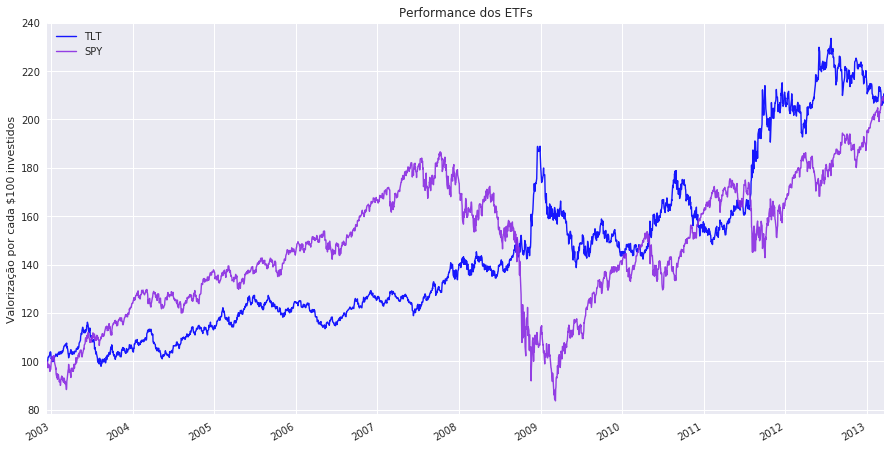

In [7]:
#### Plot ####
Quotes_norm.plot(figsize = (15, 8), color=('blue', 'blueviolet'), lw=1.4, alpha = 0.9)
plt.title('Performance dos ETFs')
plt.xlabel('')
plt.ylabel('Valorização por cada $100 investidos')

axes = plt.gca()
axes.set_xlim(['2002-12-15',"2013-03-20"])
axes.set_ylim([78,240])

plt.show()

Os valor de início e fim dos activos acima são os mesmos, ao longo de pouco mais que dez anos. Ambos os fundos apresentam, por isso, rentabilidades semelhantes. Contudo, ambos apresentam caminhos diferentes. 

Qual dos fundos prefeririam? O TLT parece menos volátil mas a verdade é que no início de 2009 teve uma queda, nada simpática, dos 190 para os 140 dólares. Podemos ver, contudo, que enquando o SPY caiu na segunda metade de 2008 o TLT subiu bastante.  Este comportamento divergente pode também ser visto na segunda metade de 2011 e primeira de 2012.

Calculando o coeficiente de Person conseguimos confirmar se as nossas impressões estão correctas.

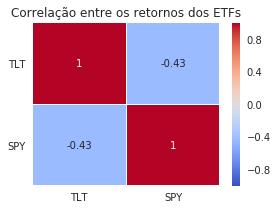

In [8]:
#### Calcular retornos ####
Returns = Quotes.pct_change()

#### Calcular a correlção entre os retornos ####
Returns_corr = Returns.corr()

#### Plot ####
fig, ax = plt.subplots()
fig.set_size_inches(4.2, 3)
sns.heatmap(Returns_corr, annot = True, cmap = "coolwarm", linewidths=.2, vmin = -1)
plt.title('Correlação entre os retornos dos ETFs')
plt.yticks(rotation=360)
plt.show()

Os retornos apresentam um coeficiente de Person negativo, mostrando que existe, de facto, uma relação inversa entre os fundos. Seguidamente vamos ver o que acontece se juntarmos ambos os fundos fazendo uma carteira de investimento com 50% em cada fundo.

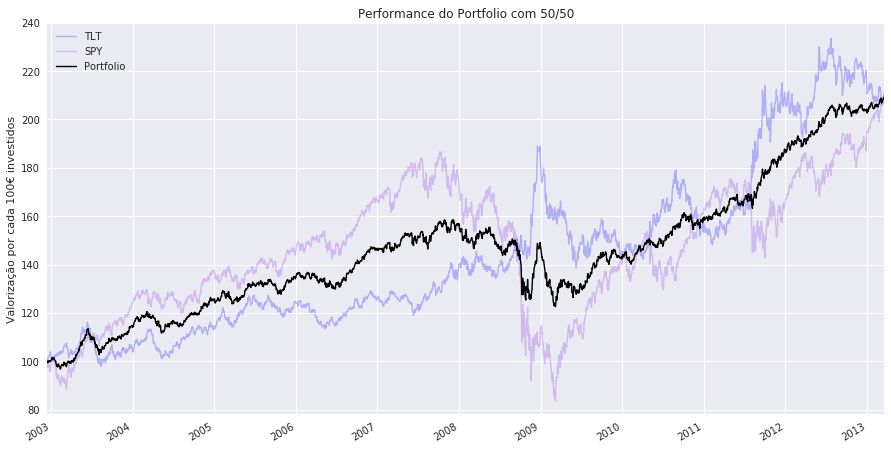

In [9]:
### weights ####
weights = np.array([0.5, 0.5])

### Calculate Portfolio value with linear algebra ####
Portfolios = Quotes_norm.copy()
Portfolios["Portfolio"] = np.dot(Portfolios, weights) # weights * quotes

### Plot ###
Portfolios['TLT'].plot(figsize = (15, 8), color='Blue', lw=1.4, alpha = 0.25)
Portfolios['SPY'].plot(figsize = (15, 8), color='Blueviolet', lw = 1.4, alpha = 0.25)
Portfolios['Portfolio'].plot(figsize = (15, 8), color='Black', lw = 1.4)

plt.title('Performance do Portfolio com 50/50')
plt.xlabel('')
plt.ylabel('Valorização por cada 100€ investidos')
plt.legend(loc='upper left')

axes = plt.gca()
axes.set_xlim(['2002-12-15',"2013-03-20"])
axes.set_ylim([78,240])

plt.show()

Uma carteira 50/50 apresenta assim uma perfomance melhor do que cada fundo individualmente, não porque teve maior rentabilidade, mas porque teve menos risco e menores quedas para obter a mesma rentabilidade dos fundos individualmente. O periodo após 2010 (inclusivé) mostra isso perfeitamente.

Vamos então calcular a tabela de performance dos fundos e do portfolio:

In [10]:
compute_performance_table(Portfolios)

TLT    SPY  Portfolio
CAGR     7.41   7.45       7.43
StdDev  14.07  20.54       9.25
Sharpe   0.53   0.36       0.80
Max DD  26.59  55.19      22.70

Podemos ver que o CAGR (rentabilidade anualizada) é uma média de ambos mas o desvio padrão (volatilidade) é significativamente inferior no Portfolio. Isso acontece exactamente porque um dos fundos sobe quando o outro desce, suavizando a performance. O Max DD (queda máxima) do portfolio foi também inferior a qualquer dos fundos individualmente.

A diversificação, feita correctamente é mesmo isso, uma diminuição do risco sem prejuízo da rentabilidade obtida. Naturalmente o portfolio apresenta um rácio de sharpe (rácio entre o retorno e o desvio padrão, sendo que quanto maior melhor) bastante mais elevado do que qualquer um dos fundos individualmente, pois obteve a mesma rentabilidade com menor risco.

Mas será 50% em cada fundo o ideal? Essa resposta será dada pela criação de uma Fronteira Eficiente de Markowitz. Markowitz foi quem, na realização da sua tese de doutoramento, desenvolveu a ideia da relação entre o risco e o retorno e a sua aplicabilidade matemática, propondo que a carteira ideal é aquela que tem maior retorno para um determinado risco.

Assim, o investidor apenas deve indicar o risco que pretende, uma vez que diferentes pessoas têm diferentes perfis de risco, e a carteira ideal é sempre a que tem maior retorno para esse nível de risco. Nada nos indica que a carteira ideal é 50/50. Se uma carteira 55/45 apresentar o mesmo risco mas um retorno maior é, com certeza, melhor.

O defeito desta optimizaçao é que é referente ao passado, uma vez que não conseguimos prever o futuro com precisão. Uma optimização costuma contudo ser superior a uma distribuição arbitrária dos pesos nos fundos, para além de nos permitir personalizar o risco pretendido.

A criação de uma carteira ideal para cada nível de risco acaba por ter um formato bastante próprio, como vamos demonstrar.

### Fronteira eficiente de Markowitz

#### A fronteira eficiente de Markowitz é o conjunto de carteiras que maximiza o retorno para os vários desvios padrões (risco).

Para a demonstração irei usar dados de 4 acções americanas. O objectivo é, ao mesmo tempo que estamos a ver as demostrações ir aproximando os resultados aos resultados e gráficos que vamos usar na constituição da nossa carteira.

As acções que vamos usar serão a Apple, Amazon, Cisco e IBM no período compreendido entre início de 2012 e finais de 2016.

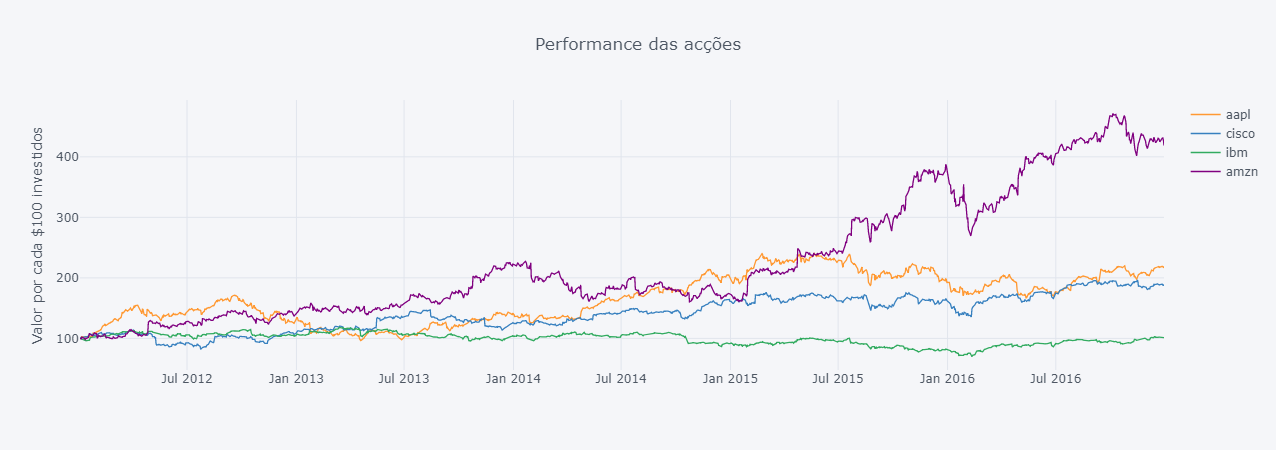

In [11]:
# Download and get Daily Returns
aapl = pd.read_csv('AAPL_CLOSE',index_col='Date',parse_dates=True)
cisco = pd.read_csv('CISCO_CLOSE',index_col='Date',parse_dates=True)
ibm = pd.read_csv('IBM_CLOSE',index_col='Date',parse_dates=True)
amzn = pd.read_csv('AMZN_CLOSE',index_col='Date',parse_dates=True)

# Concatenating
stocks = pd.concat([aapl,cisco,ibm,amzn],axis=1)
stocks.columns = ['aapl','cisco','ibm','amzn']

# Mean
mean_daily_ret = stocks.pct_change(1).mean()

stock_normed = stocks/stocks.iloc[0]
round(stock_normed.mul(100), 2).iplot(yTitle='Valor por cada $100 investidos', title='Performance das acções')

In [12]:
# Set seed (optional)
np.random.seed(0)

# Returns
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

# Create Random Weights
weights = np.array(np.random.random(4))

# Rebalance Weights
weights = weights / np.sum(weights)

# Expected Return
exp_ret = np.sum(log_ret.mean() * weights) *252

# Expected Variance
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

# Sharpe Ratio
SR = exp_ret/exp_vol

### Running Monte Carlo Simulation
num_ports = 100000

all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):
    
    weights = np.array(np.random.random(4))  # Create Random Weights
    weights = weights / np.sum(weights)  # Rebalance Weights
    all_weights[ind,:] = weights  # Save Weights
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)   # Expected Return
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))  # Expected Variance
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]   # Sharpe Ratio

Para o cálculo da fronteira eficiente de Markovitz podemos seguir o caminho de optimização matemática ou simplemente uma simulação de Monte-Carlo. Vamos seguir pelo caminho da simulação de Monte Carlo onde iremos criar uma grande quantidade de carteiras com pesos aleatórios entre as acções para verificar qual teria sido a melhor alocação nas 4 acções.

Abaixo podemos ver um gráfico com 100 mil carteiras (cada ponto é uma carteira) com pesos escolhidos aleatóricamente pelo computador.  Para uma volatilidade de 20% podemos ver que há carteiras com retorno de 20% anualizado mas também há carteiras com 12 ou 13% de rentabilidade. O objectivo será escolher uma das carteiras com melhor rentabilidade para o risco pretendido. Se optarmos por 20% de volatilidade, naturalmente a que tem maior rentabilidade é superior.

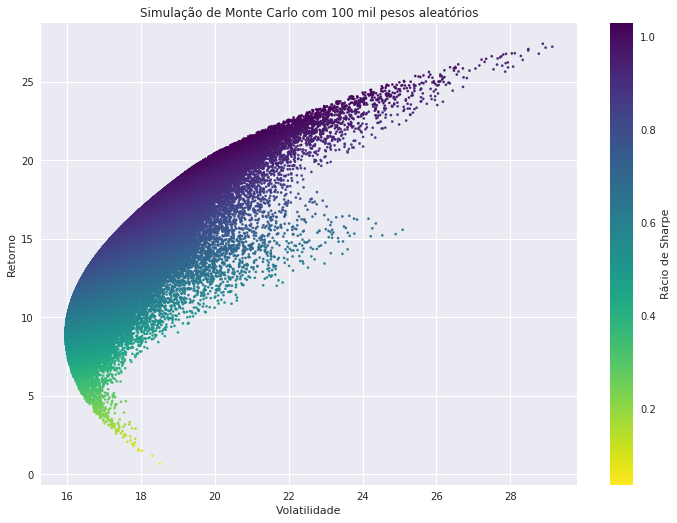

In [13]:
plt.figure(figsize=(12,8.5))
plt.scatter(vol_arr * 100, ret_arr * 100, c=sharpe_arr, cmap='viridis_r', s = 5)
plt.colorbar(label='Rácio de Sharpe')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.title('Simulação de Monte Carlo com 100 mil pesos aleatórios')
plt.show()

# Add red dot for max SR
# plt.scatter(max_sr_vol,max_sr_ret,c='red',s=20,edgecolors='black')

Acabamos de perceber que o que queremos são as carteiras no topo do gráfico, fazendo assim definitivamente a fronteira de todos os portfolios que maximizam o retorno para cada dada volatilidade. Podemos então sobrepôr uma linha (fronteira) ao gráfico com os 100 mil portfolios.

In [14]:
def get_ret_vol_sr(weights):
    """
    Takes in weights, returns array or return,volatility, sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

from scipy.optimize import minimize

def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

# Contraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1

# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.25,0.25]

# Sequential Least SQuares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

# Our returns go from 0 to somewhere along 0.3
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.3,100)

def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

frontier_volatility = []

for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)    
    frontier_volatility.append(result['fun'])

frontier_volatility = [x * 100 for x in frontier_volatility]
frontier_y = [x * 100 for x in frontier_y]

frontier_volatility = frontier_volatility[29:93]
frontier_y = frontier_y[29:93]

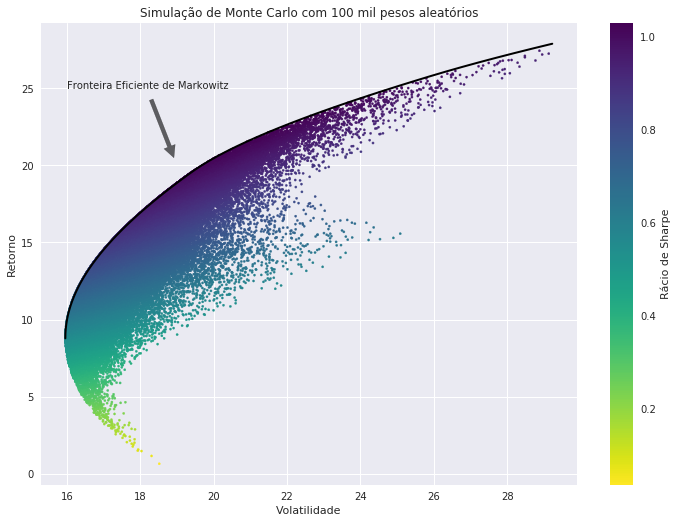

In [15]:
plt.figure(figsize=(12,8.5))
plt.scatter(vol_arr * 100, ret_arr * 100, c=sharpe_arr, cmap='viridis_r', s = 5)
plt.colorbar(label='Rácio de Sharpe')
plt.xlabel('Volatilidade')
plt.ylabel('Retorno')
plt.title('Simulação de Monte Carlo com 100 mil pesos aleatórios')
plt.annotate('Fronteira Eficiente de Markowitz', xy=(19, 20), xytext=(16, 25),
           arrowprops=dict(facecolor='black', shrink=0.1, alpha = 0.6),
         )

# Add frontier line
plt.plot(frontier_volatility, frontier_y, 'black', linewidth=2)
plt.show()

A fronteira eficiente de Markowitz marca todos os portfolios que têm o melhor retorno dado esse nível de volatilidade que são os pontos ao longo da fronteira. Todas as outras carteiras são ineficientes, podendo por isso ser descartadas.

# 2 - Por quanto tempo se deve investir?

### 2.1 Valor temporal do dinheiro e o poder dos juros de juros

Em cima mostrei que um dos principais objectivos do investimento é fazer com que a poupança não perca o seu valor real. Tentarei agora mostrar as possibilidades de aumentar, tanto o valor nominal, como o valor real, das poupanças caso façamos investimento de longo prazo. De igual forma aperceber-se-ão que até 1 ano faz diferença, pois nos últimos anos a os juros compostos faz com que os investimentos valorizem exponencialmente.

Uma das maiores vantagens de investimentos de longo prazo são juros compostos.  Passo a explicar e demonstrar a diferença entre investimentos com juros simples e juros compostos ao longo de 25 anos com uma taxa de juro de 6%.

Usei o 6% porque queria um número realista de uma carteira moderada. Nos Estados Unidos usam muito os 10% (+/- a rentabilidade histórica anualizada do S&P).

Os juros simples são investimentos em que apenas se ganha os juros. Como exemplo temos a pessoa que faz um depósito a prazo anual e no fim do ano tira sempre os juros para a conta à ordem. Por outro lado, os juros compostos é, numa mesma situação, uma pessoa que no ano 2 já faz um depósito com todo o dinheiro, isto é o investimento inicial mais os juros ganhos no primeiro ano.

In [16]:
%%capture

anos = np.arange(1, 31)

df = pd.DataFrame(anos)

df['Principal'] = 100

df.columns = ['Ano', 'Principal']

df['Simples'] = 0

df['Composto'] = 0

df.set_index('Ano', inplace=True)

for i in np.arange(0, len(df)):
    df['Simples'].iloc[i] = df['Principal'].iloc[i] + (df['Principal'].iloc[i] * 0.06 * (i +1))
    
for i in np.arange(0, len(df)):
    df['Composto'].iloc[i] = df['Principal'].iloc[i] * 1.06**(i+1)
    
df = round(df, 2)

df['Juros simples'] = df['Simples'] - df['Principal']

df['Juro composto'] = df['Composto'] - df['Principal']

df['Juros de juros'] = df['Juro composto'] - df['Juros simples']

ano_zero = pd.DataFrame([0, 100, 100, 100, 0, 0, 0]).transpose()

ano_zero.columns = ['Ano', 'Principal', 'Simples', 'Composto', 'Juros simples', 'Juro composto', 'Juros de juros']

df = ano_zero.merge(df, how='outer')

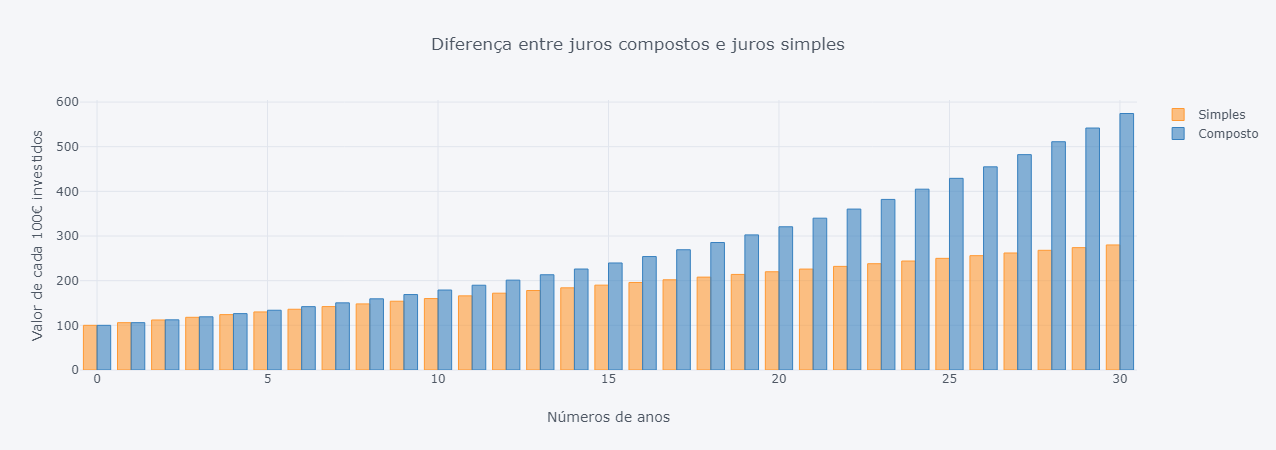

In [17]:
df[['Simples', 'Composto']].iplot(kind='bar', yTitle='Valor de cada 100€ investidos', xTitle='Números de anos',
                                   title='Diferença entre juros compostos e juros simples')

Pode-se ver que a diferença é abismal. Em 30 anos com juros simples os 100 euros transformaram-se em 280 euros mas em juros compostos os 100 euros transformaram-se em 574 euros, ligeiramente mais do dobro.

30 anos pode parecer muito mas no fundo é uma pessoa entre os 35 e 40 anos que começou a poupar para a reforma.

_P.S. - O uso da base 100 deve-se a tornar muito simples calcular percentagens._

##### Porquê esta diferença toda?

A diferença está nos juros dos juros. No primeiro ano, em juros compostos, os juros são sobre 100 euros, mas no segundo já são sobre 106 euros, e no terceiro sobre 112.36 euros. Estes 36 cêntimos são juros dos juros que tínhamos ganho no ano anterior.

À primeira vista esses 36 cêntimos parecem pouco mas a verdade é que a 6%, no ano 13 já estão a ganhar mais juros de juros do que juros simples (6 euros de 'juros simples' e 6.07 euros de _'juros de juros'_) e no ano 23 o montante total ganho por _'juro de juros'_ já é superior aos _'juros simples'_.

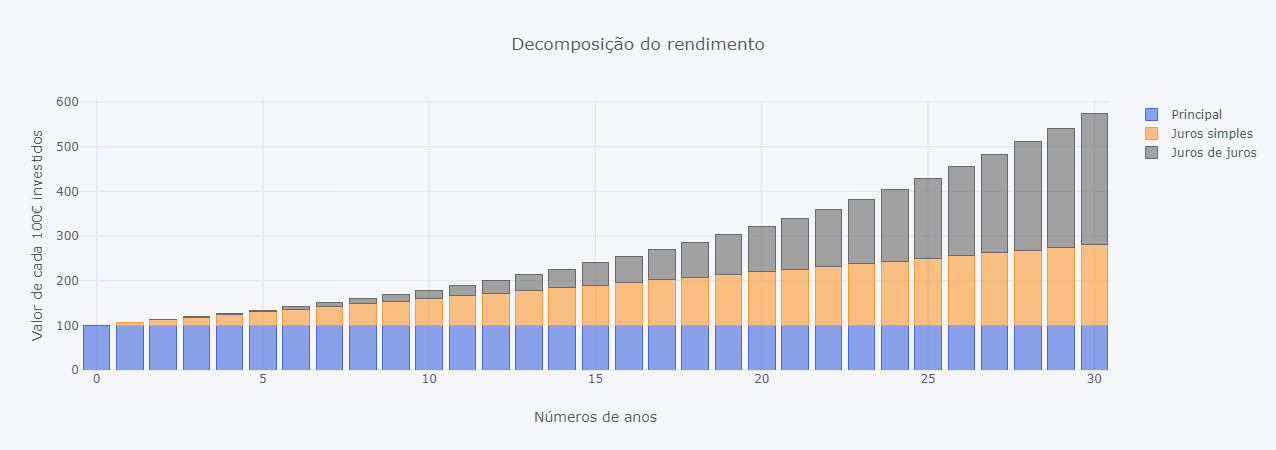

In [18]:
df[['Principal', 'Juros simples', 'Juros de juros']].iplot(kind='bar',barmode='stack',
                                                          yTitle='Valor de cada 100€ investidos',
                                                          xTitle='Números de anos',
                                                          colors=['royalblue', 'orange', 'dimgray'],
                                                          title='Decomposição do rendimento')

Por último acabei por fazer um gráfico de área, pois dá para nos apercebermos melhor daquele crescimento exponential que os juros de juros começam a ter.

Naturalmente, esta é uma forte razão para que o período de investimento deva ser o maior possível e que devemos começar a poupar o mais cedo possível.

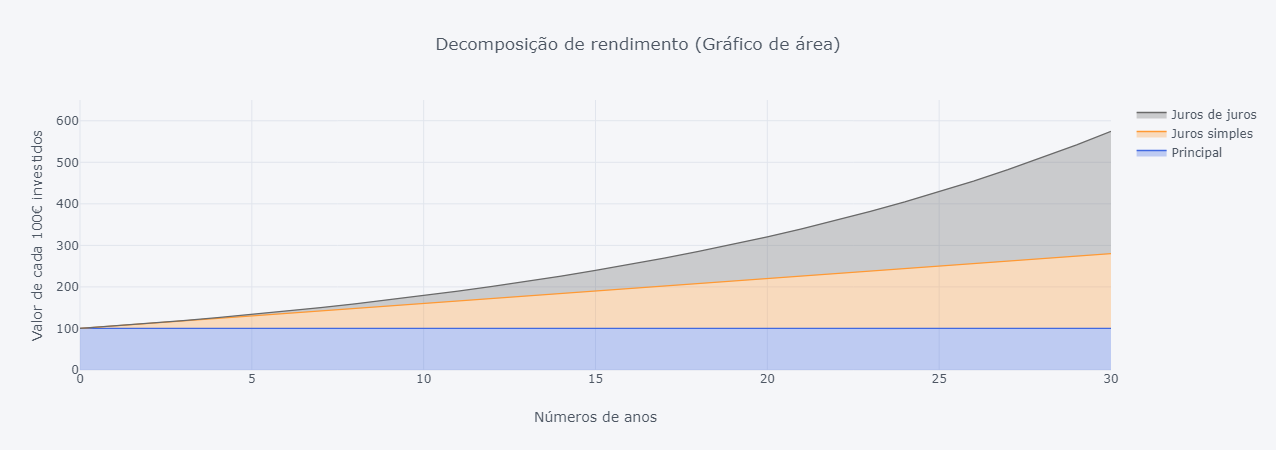

In [19]:
df[['Principal', 'Juros simples', 'Juros de juros']].iplot(kind='area',
                                                                   yTitle='Valor de cada 100€ investidos',
                                                                   xTitle='Números de anos',
                                                                   yrange=[0, 650], fill=True,
                                                                   colors=['royalblue', 'orange', 'dimgray'],
                                                                   title='Decomposição de rendimento (Gráfico de área)')

#### 3.2 Menor variabilidade nos retornos de longo prazo

Este conceito continua o anterior no sentido que é outra boa razão para investimento de longo prazo. 

Menor variabilidade de retorno de longo prazo significa que quanto maior o tempo de investimento menor serão os valores alvo da rentabilidade e por isso com mais certeza poderemos ter na criação das nossas expectativas.

Para mostrar o que falo vamos voltar a ir buscar a nossa carteira com SPY, TLT e o Portolio 50/50. Em baixo o gráfico actualizado até ao presente.

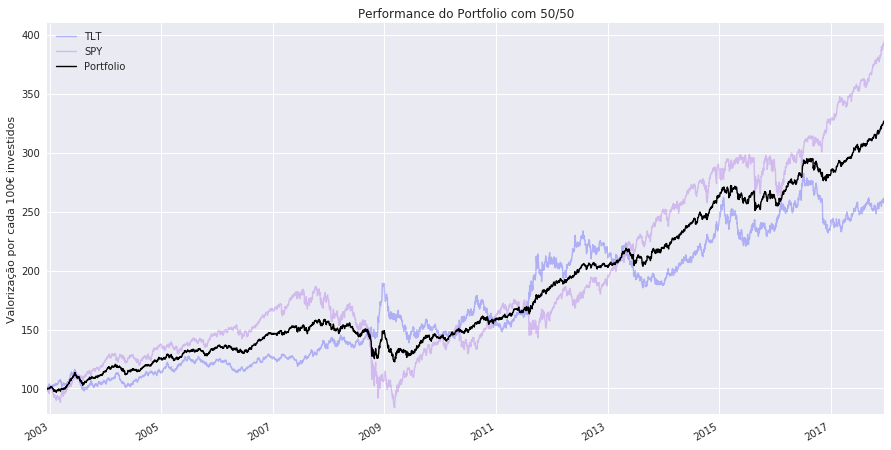

In [21]:
# download quotes
tickers = ['TLT', 'SPY']
Quotes = pd.DataFrame()
Start ='2002-12-15'
End = "2017-12-18"

for t in tickers:
    Quotes[t] = pdr.get_data_yahoo(t, start=Start, end=End)['Adj Close'] 
    
#### Normalization to 100 ####
Quotes_norm = (Quotes / Quotes.iloc[0] * 100)

### weights ####
weights = np.array([0.5, 0.5])

### Calculate Portfolio value with linear algebra ####
Portfolios = Quotes_norm.copy()
Portfolios["Portfolio"] = np.dot(Portfolios, weights) # weights * quotes

### Plot ###
Portfolios['TLT'].plot(figsize = (15, 8), color='Blue', lw=1.4, alpha = 0.25)
Portfolios['SPY'].plot(figsize = (15, 8), color='Blueviolet', lw = 1.4, alpha = 0.25)
Portfolios['Portfolio'].plot(figsize = (15, 8), color='Black', lw = 1.4)

plt.title('Performance do Portfolio com 50/50')
plt.xlabel('')
plt.ylabel('Valorização por cada 100€ investidos')
plt.legend(loc='upper left')

axes = plt.gca()
axes.set_xlim([Start, End])
axes.set_ylim([78,410])

plt.show()

Como podemos ver o portfolio continuou a sua ascenção em linha com o que tinha acontecido até inícios de 2013, que foi onde o tinhamos deixado.

O que quero dizer com 'Menor variabilidade de retorno de longo prazo' é exactamente o que mostro em baixo.

In [22]:
One_year = multi_period_return(Portfolios, years = 1)
Three_years = multi_period_return(Portfolios, years = 3)
Five_years = multi_period_return(Portfolios, years = 5)
Ten_years = multi_period_return(Portfolios, years = 10)

Portolio_rol = pd.DataFrame()

Portolio_rol['Um ano'] = One_year['Portfolio']
Portolio_rol['Três anos'] = Three_years['Portfolio']
Portolio_rol['Cinco anos'] = Five_years['Portfolio']
Portolio_rol['Dez anos'] =  Ten_years['Portfolio']

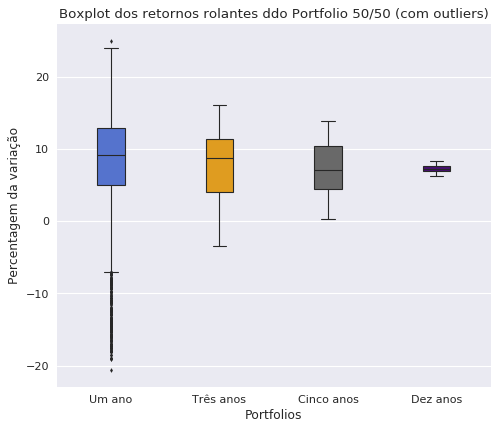

In [23]:
my_pal = ["royalblue", "orange", "dimgrey", 'indigo']

plt.figure(figsize=(7, 6), dpi=80)
ax = sns.boxplot(data=Portolio_rol, orient="v", linewidth=1, width=0.25, fliersize=3,  palette=my_pal, whis=1.5)
ax.set_title("Boxplot dos retornos rolantes ddo Portfolio 50/50 (com outliers)")
ax.set_xlabel('Portfolios')
ax.set_ylabel('Percentagem da variação')
plt.show()

Estas barras mostram a amplitude dos retornos a 1, 3, 5, e 10 anos.

Como facilmente se pode ver para quem investiu a 1 ano facilmente poderia ter tido um retorno de mais de 20% mas também um retorno de -8%. Numa situação extrema o Portfolio apresentou até retornos negativos perto dos -20% (quem apanhou a crise de 2008).

Podemos ver, contudo, que quem investiu a 3 anos teve retornos máximos na linha dos 16%/ano mas também nunca teve retornos abaixo de -4%/ano.

Por seu lado, quem inventiu a 5 anos teve sempre retornos positivos, nem que tenha sido apenas marginalmente, sendo que o "normal" são retornos entre os 5 e os 10% (o _'normal'_ é mesmo os retornos estarem dentro da barra).

Finalmente, a 10 anos podemos ver que há muito pouca amplitude e um retorno muito centrado nos 7%.

Não quer dizer que estes retornos se vão manter, afinal não sabemos os retornos futuros. Mas com certeza o facto de que quanto maior o tempo de investimento menor a amplitude de retornos, se irá manter.

Mostro visualmente o que os dados nos dizem:

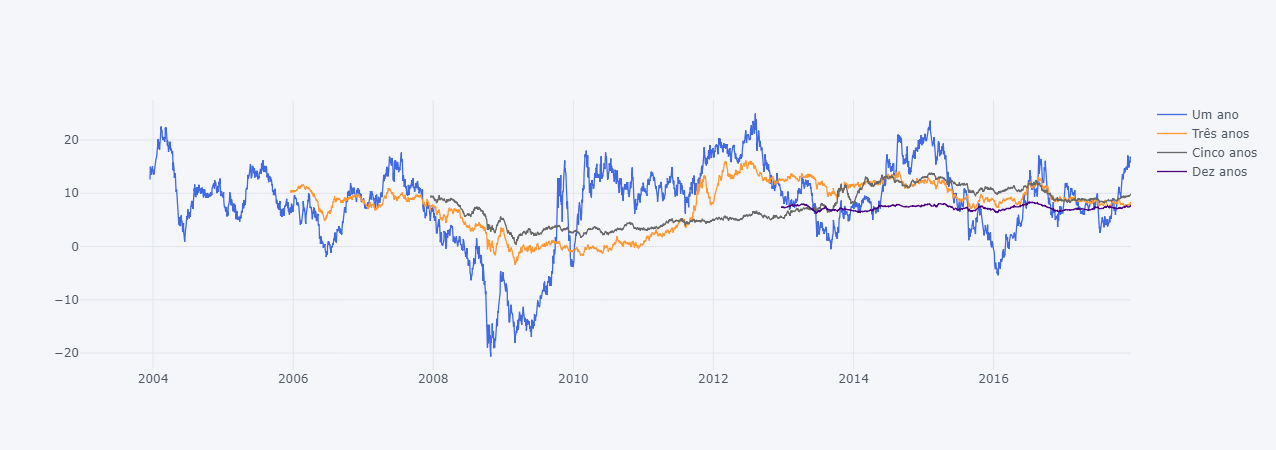

In [24]:
round(Portolio_rol, 2).iplot(colors=my_pal)

Podemos aqui ver a um ano o retorno varia imenso, indo várias vezes a 20% mas por seu lado indo também a negativo.  Apercebemo-nos também que, quanto maior o prazo, mais estável a linha de retornos, como esperado e os dados nos mostravam.

##### Conclusão

Finalizo, assim a primeira parte da apresentação, que foi focada nos conceitos fundamentais que deveremos saber antes de investir. Quem quiser saber todos os promenores mais técnicos da construção de uma carteira pode passar ao segundo ficheiro. Será também relevante para o caso de se fazer uma carteira mais personalizada.

Por outro lado, e sem perda relevante de conhecimento para investirmos, quem quiser saltar estas partes mais técnicas pode ir já para o terceiro ficheiro e ver a análise aprofundada a 3 carteiras já feitas e que tenho usado com sucesso.